In [55]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import copy
from tqdm import tqdm


In [56]:
# tutorial from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Runnning on {device}')

base_dir = 'data/hymenoptera_data/'
num_classes = 2 # bees, ants
input_size = 256

# Noramlization constants for pretrained models

mean_norm = [0.485, 0.456, 0.406] 
std_norm = [0.229, 0.224, 0.225]



Runnning on cpu


In [60]:
transform = transforms.Compose([transforms.RandomResizedCrop(input_size),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean_norm, std_norm)
                                ])


# create dataset
train_dataset = datasets.ImageFolder(base_dir+'train/', transform=transform)
test_dataset = datasets.ImageFolder(base_dir+'val/', transform= transform)

# create dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=1) # larger batch size for validation



In [61]:

def view_tensor(x):
    for c in range(3):
        x[c] *= std_norm[c]
        x[c] += mean_norm[c]
    
    to_pil = torchvision.transforms.ToPILImage()
    img = to_pil(x)
    plt.imshow(img)

def view_sample(index):
    x,y = train_dataset[index]
    
    for c in range(3):
        x[c] *= std_norm[c]
        x[c] += mean_norm[c]
    
    to_pil = torchvision.transforms.ToPILImage()
    img = to_pil(x)
    plt.imshow(img)
    label = "Ant" if y==0 else "Bee"
    plt.title(label)

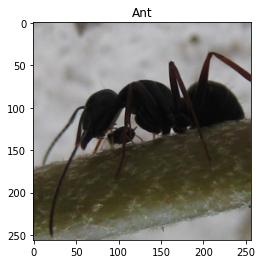

In [62]:
view_sample(11)

In [ ]:
# Load in model and remove gradients. 
# Removing gradients means that all paramters will be set to zero. 
# Only the last fully connected layer will be trained

In [63]:
model_ft = models.resnet34(pretrained=True)
for p in model_ft.parameters():
    p.requires_grad = False


In [73]:
# re-initialize the last fully connected layer. This is the only layer we're training
model_ft.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
model_ft.num_classes = num_classes
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [65]:
print('Parameters to train:')
for p in model_ft.named_parameters():
    if p[1].requires_grad == True:
        print(p[0])

Parameters to train:
fc.weight
fc.bias


In [66]:
# Specify optimizer and loss function

In [67]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [68]:
# function to compute validation accuracy and loss 
def metrics(dataloader,model,criterion,device):
        inputs,labels = next(iter(dataloader))
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        preds = torch.argmax(outputs,1)
        if len(preds) == len(labels):
            acc = torch.sum((preds == labels)*1.).item()/len(preds)

        loss = criterion(outputs,labels).item()
        
        return acc,loss


In [69]:
# store training metrics in this dict
metrics_dict = {
    "epoch":[],
    "iter":[],
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]
}

In [70]:
for epoch in range(2):
    for i,(inputs, labels) in enumerate(train_dataloader):

        inputs = inputs.to(device)
        labels = labels.to(device)

        #Train
        model_ft.train()

        optimizer_ft.zero_grad()
        outputs = model_ft(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer_ft.step()
        
        # Done training 
        model_ft.eval()

        if i% 5 == 0:
            with torch.no_grad():
                # take a random batch and see what's the loss and accuracy
                train_acc, train_loss = metrics(train_dataloader,model_ft,criterion,device)
                val_acc, val_loss = metrics(test_dataloader,model_ft,criterion,device)
                
                # save to dict
                metrics_dict['epoch'].append(epoch)
                metrics_dict['iter'].append(i)
                metrics_dict['train_loss'].append(train_loss)
                metrics_dict['train_acc'].append(train_acc)
                metrics_dict['val_loss'].append(val_loss)
                metrics_dict['val_acc'].append(val_acc)


In [71]:
df = pd.DataFrame(metrics_dict)

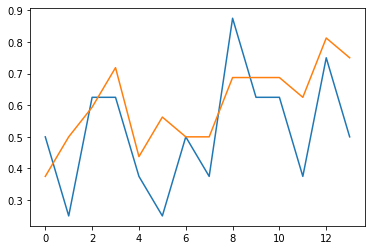

In [72]:
plt.plot(df['train_acc'])
plt.plot(df['val_acc'])


# TODO:

- Confusion matrix
- top losses
- Upload an image and you get what it is?